# T/S Diagram from ECCO

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import json
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [5]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [2]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/ECCO/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

ds_tns = open_ds('ds_tns_wg.zarr')
#coords = open_ds('coords_wg.zarr')

In [3]:
#all this to load in coords without roll_coords=True
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coordsr = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)

#view current coord structure of i
coordsr.i.values
#locate 0, that's where -180 is
coordsr.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
coordsr['i'] = lon_rolled
coordsr['i_g'] = lon_rolled

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

coords = coordsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

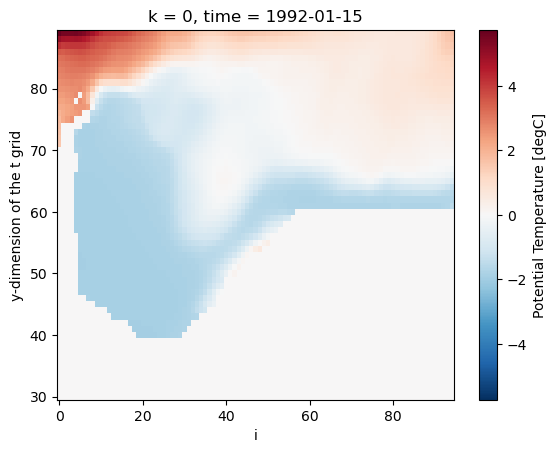

In [7]:
ds_tns.THETA[0,0].drop('i').plot()

## **TRY TO PLOT EVERY TIMESTEP WITH XMOVIE**

### Juliu's XMovie package

In [ ]:
from xmovie import Movie

In [ ]:
def custom_plotfunc(ds, fig, tt, salt=ds.SALT, temp=ds.THETA, Z=coords.Z):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    _, _, lev_broadcasted = xr.broadcast(salt, temp, coords.Z)
    
    ax = fig.subplots()
    
    scat = ax.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)
    fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))
    
    ax.set_xlim(33.4, 35)
    ax.set_ylim(-2, 1.2)

    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    ax.set_title('T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [ ]:
#creating movie object
mov = Movie(ds.time, plotfunc=custom_plotfunc, 
            salt=ds.SALT, temp=ds.THETA, 
            Z=coords.Z, input_check=False, dpi=150)

In [ ]:
#frame preview
mov.preview(3)

In [ ]:
#create a movie!

#ds = ds.isel(time=slice(0, 10))

mov = Movie(ds.time, plotfunc=custom_plotfunc, 
            salt=ds.SALT, 
            temp=ds.THETA, 
            Z=coords.Z, input_check=False)
mov.save('movie_full_ECCO.mp4', progress=True)

# xhistogram T/S Diagram from ECCO

In [9]:
#salt_bins = np.linspace(31.5, 35.5, 100)
#theta_bins = np.linspace(-2, 4, 100)
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF)

In [10]:
vol.sum().values

array(2.8658932e+16, dtype=float32)

In [11]:
salt = ds_tns.SALT
temp = ds_tns.THETA

In [12]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['i', 'j', 'k']).rename({'THETA_bin':'theta_bin',
                                                              'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 288, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(288, 99, 99), dtype=float32, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [13]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.sel(time=slice('2005', '2012')).mean(dim='time')

In [14]:
ts_hist_mean.to_netcdf('ts_hist_mean_ECCO.nc', mode='w')

# Load in `ts_hist_mean_ECCO.nc` ds and plot

In [15]:
ts_hist_mean = xr.open_dataarray('ts_hist_mean_ECCO.nc')

In [16]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [ ]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), 
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                                        cmap='Blues', vmin=1e14, vmax=1e18)

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

Text(0, 0.5, 'Potential Temperature [˚C]')

# Adding isopycnal contours & potential temp/abs salt
to xhistogram plot

In [22]:
from fastjmd95 import jmd95numba

In [23]:
sigma2 = jmd95numba.rho(ts_hist_mean.salt_bin, ts_hist_mean.theta_bin, 2000.)

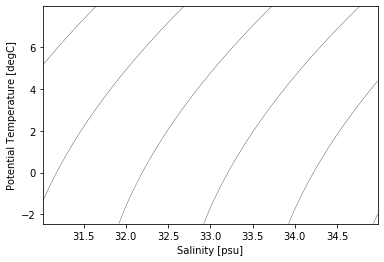

In [24]:
sigma2.transpose().plot.contour(colors='k', linewidths=0.3);

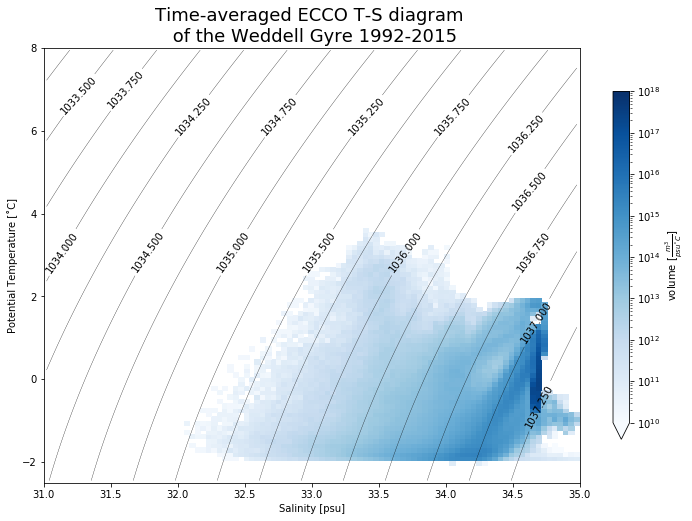

In [43]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
hist = ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e10, vmax=1e18,
                                               cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Time-averaged ECCO T-S diagram \n of the Weddell Gyre 1992-2015', fontsize=18);

## Movie!

In [ ]:
def xhist_plot(dsr, fig, tt, salt=salt, temp=temp):

    salt = salt.isel(time=tt)
    temp = temp.isel(time=tt)

    pressure = xr.apply_ufunc(gsw.p_from_z, coords.Z, lat, output_dtypes=[coords.Z.dtype], dask='parallelized').reset_coords(drop=True)
    sa = xr.apply_ufunc(gsw.SA_from_SP, salt, pressure, lon, lat, output_dtypes=[salt.dtype], dask='parallelized').reset_coords(drop=True)
    sa.name = 'SA'
    ct = xr.apply_ufunc(gsw.CT_from_pt, sa, temp, output_dtypes=[temp.dtype], dask='parallelized').reset_coords(drop=True)
    ct.name = 'CT'
   
    sa_bins = np.linspace(31, 35, 100)
    ct_bins = np.linspace(-2.5, 8, 100)
    
    delta_sa = sa_bins[1] - sa_bins[0]
    delta_ct = ct_bins[1] - ct_bins[0]
    
    vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
    

    
    #define sigma grid
    
    xdim_sa = np.arange(31, 35, 0.1)
    ydim_ct = np.arange(-2.5, 8, 0.1)
    
    sigma = np.empty([40, 105])
    for j in range(40):
        for i in range(105):
            sigma[j, i] = gsw.sigma2(xdim_sa[j], ydim_ct[i])
        
    #Plotting
    
    ax = fig.subplots()
    
    ts_hist = histogram(ct, sa, bins=[ct_bins, sa_bins],
                    weights=vol, dim=['i', 'j', 'k']).rename({'CT_bin':'ct_bin',
                                                              'SA_bin':'sa_bin'}) / (delta_salt * delta_theta)
    
    C = ax.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.5)
    ax.clabel(C)
    
    hist = ts_hist.where(ts_hist>0).plot(norm=LogNorm(), ax=ax, cmap='Blues', vmin=1e14, vmax=1e18,
                                         cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
  
    timestamp = str(dsr.time.isel(time=tt).values)
    ax.text(x=33,y=-4.2, s=timestamp[:10], 
            fontsize=18, weight='bold', horizontalalignment='center')
    
    ax.set_title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
    ax.set_xlabel('Absolute Salinity [g/kg]')
    ax.set_ylabel('Conservative Temperature [˚C]')

    fig.subplots_adjust(top=0.8)
    
    return ax, hist

In [ ]:
#creating movie object
mov = Movie(ds.time, plotfunc=xhist_plot, 
            salt=salt, temp=temp, input_check=False, dpi=150)
#mov.save('movie.mp4')

In [ ]:
%matplotlib inline

In [ ]:
#frame preview
mov.preview(3)

In [ ]:
#frame preview
mov.preview(30)

In [ ]:
#create a movie!

#dsr = ds.isel(time=slice(0,21))

mov = Movie(ds.time, plotfunc=xhist_plot, 
            salt=salt, 
            temp=temp, 
            input_check=False, dpi=150)

mov.save('xhist_isopycnals_ECCO_Blues.mp4', progress=True)